# Human Emotion Detection - Farid's Notebook

In [1]:
import os
import pathlib

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import PIL.Image
import seaborn as sns

# import numpy as np
import tensorflow as tf

random_state = 42

%matplotlib inline

In [2]:
# For Google Colab Only
# Mount GDrive
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# For Google Colab Only
# Put Colab in the context of this challenge

# os.chdir allows you to change directories, like cd in the Terminal
os.chdir("/content/drive/MyDrive/Colab Notebooks/EmoSense/notebooks")

## Exploratory Data Analysis (EDA)

### Loading and Cleaning the Data

In [4]:
cwd = os.getcwd()
data_path = pathlib.Path(cwd, "..", "raw_data")
cache_path = pathlib.Path(cwd, "..", "cache")

df = pd.DataFrame(columns=["filename", "label"])
with os.scandir(data_path) as entries:
    for entry in entries:
        entry_path = os.path.join(data_path, entry)
        if os.path.isdir(entry_path):
            filelist = [f.name for f in os.scandir(entry_path)]
            df = pd.concat(
                [df, pd.DataFrame({"filename": filelist, "label": entry.name})]
            )

df.reset_index(inplace=True, drop=True)
df.describe()

,filename,label
count,5558,5558
unique,5233,8
top,2Q__ (2)_face.png,happiness
freq,6,1406


It looks like some files appear in multiple folders. We need to make sure these are not actual duplicate images. Because if that is the case, it makes the problem one of "multilabel" image classification. First, let's find out how many file _names_ are duplicated...

In [5]:
dups = df[df["filename"].duplicated(keep=False)]
dups["filename"].nunique()

125

Let's take a look at some of these...

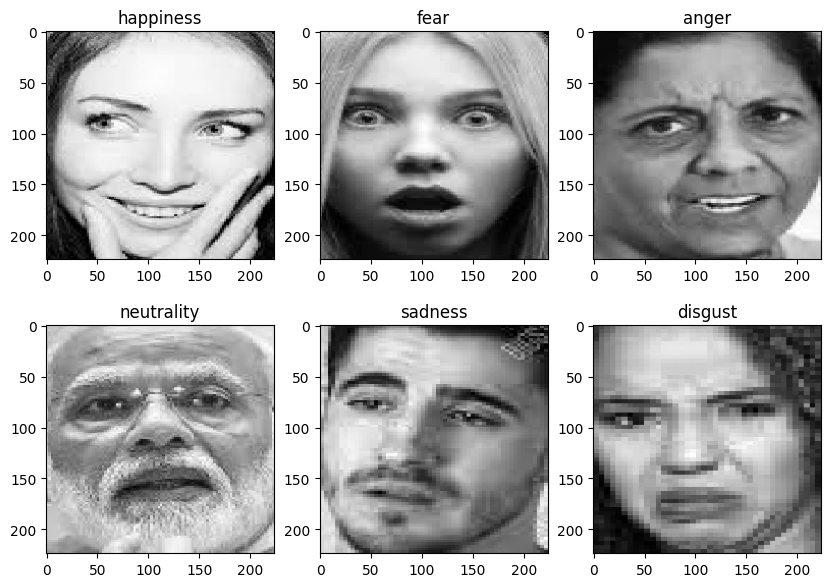

In [6]:
fig = plt.figure(figsize=(10, 7))
i = 0
for row in df.query("filename == 'images (55)_face.png'").iterrows():
    filename = row[1][0]
    label = row[1][1]
    path = os.path.join(data_path, label, filename)
    ax = fig.add_subplot(2, 3, i + 1)
    img = mpimg.imread(path)
    ax.imshow(img, cmap="gray")
    ax.title.set_text(label)
    i = i + 1

Looks like they're actually different images. We've only looked at one duplicated file name but hopefully it's safe to assume this applies to all the other ones as well 🤞 and we can continue with multiclass classification.  
For future reference and in case we do need to drop duplicates in the future:
```python
df = df.drop_duplicates(subset=["filename"], keep=False)
df.describe()
```

### Data Imbalance

Now let's take a look at the distribution of labels...

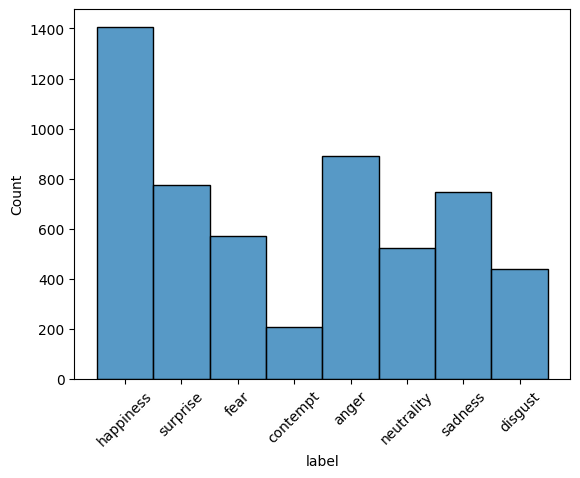

In [7]:
ax = sns.histplot(df.label)
ax.tick_params(axis="x", rotation=45);

The data looks quite unbalanced...  
**<u>TO DO</u>:** Use stratified sampling or try balancing the dataset using over/under-sampling methods (SMOTE, etc.), data augmentation, etc. 

## Preparing the Data

Let's encode the labels first. We could use `sklearn.preprocessing.OneHotEncoder`, but I'd like to use `tf.keras.utils.to_categorical` this time...

In [8]:
i = 0
label_dict = {}
with os.scandir(data_path) as entries:
    for entry in entries:
        entry_path = os.path.join(data_path, entry)
        if os.path.isdir(entry_path):
            label_dict[entry.name] = i
        i = i + 1
label_dict

{'happiness': 0,
 'surprise': 1,
 'fear': 2,
 'contempt': 3,
 'anger': 4,
 'neutrality': 5,
 'sadness': 6,
 'disgust': 7}

In [9]:
df["label_int"] = df.label.apply(lambda x: label_dict[x])

df.sample(n=5)

,filename,label,label_int
2874,images - 2020-11-06T181712.561_face.png,contempt,3
3240,images - 2020-11-06T003602.014_face.png,anger,4
2959,372662640_e8dc799d8b_b_face.png,anger,4
1576,images - 2020-11-06T202518.735_face.png,surprise,1
3189,images - 2020-11-06T003440.243_face.png,anger,4


In [10]:
from tensorflow.keras.utils import to_categorical

n_classes = len(label_dict)
y = to_categorical(df.label_int, n_classes)
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Let's also replace the `filename` column with the full path to each file to make things easier...

In [11]:
df["filepath"] = df.apply(
    lambda x: os.path.join(data_path, x["label"], x["filename"]), axis=1
)
df.drop(columns="filename", inplace=True)

In [12]:
df.sample(n=5)

,label,label_int,filepath
5257,disgust,7,/content/drive/MyDrive/Colab Notebooks/EmoSens...
5098,sadness,6,/content/drive/MyDrive/Colab Notebooks/EmoSens...
4070,neutrality,5,/content/drive/MyDrive/Colab Notebooks/EmoSens...
530,happiness,0,/content/drive/MyDrive/Colab Notebooks/EmoSens...
2387,fear,2,/content/drive/MyDrive/Colab Notebooks/EmoSens...


In [13]:
X = df.filepath
X

0       /content/drive/MyDrive/Colab Notebooks/EmoSens...
1       /content/drive/MyDrive/Colab Notebooks/EmoSens...
2       /content/drive/MyDrive/Colab Notebooks/EmoSens...
3       /content/drive/MyDrive/Colab Notebooks/EmoSens...
4       /content/drive/MyDrive/Colab Notebooks/EmoSens...
                              ...                        
5553    /content/drive/MyDrive/Colab Notebooks/EmoSens...
5554    /content/drive/MyDrive/Colab Notebooks/EmoSens...
5555    /content/drive/MyDrive/Colab Notebooks/EmoSens...
5556    /content/drive/MyDrive/Colab Notebooks/EmoSens...
5557    /content/drive/MyDrive/Colab Notebooks/EmoSens...
Name: filepath, Length: 5558, dtype: object

Now we have everything we need in order to create the training, validation and test data sets.

In [14]:
# Next, some common CONSTants...

BATCH_SIZE = 32
IMG_DIM = 224  # height = width
N_CHANNELS = 3  # The input images are greyscale but we need RGB in order to use pre-trained models

# Note: In Python 3.7+ dictionaries are ordered.
class_names = list(label_dict.keys())

# This flag controls whether to go down the "manual" route ('False') or use the TensorFlow.Keras utility function ('True')
USE_TF_KERAS_UTIL = False

### Route 1: Manually (Creating `tf.data.Dataset` Objects)

Now some preprocessing and helper functions...

In [15]:
# In order to do 'transfer learning' using VGG16, ResNet, etc. our image needs to have three channels.
# We will simply duplicate the one grayscale channel 2 more times.
def expand_greyscale_image_channels(image):
    if image.shape[-1] == 1:
        grey_image_3_channel = tf.tile(image, tf.constant([1, 1, 3], tf.int32))
    else:
        grey_image_3_channel = image

    return tf.keras.applications.mobilenet_v2.preprocess_input(grey_image_3_channel)

In [16]:
def parse_function(filepath, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    # image_string = tf.io.read_file(filename)
    image_string = tf.io.read_file(filepath)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_png(image_string, channels=N_CHANNELS)
    # Resize it to fixed shape - NOT NECESSARY
    image_resized = (
        image_decoded  # tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    )
    # Normalize it from [0, 255] to [0.0, 1.0] - NOT NECESSARY
    image_normalized = tf.cast(
        image_resized, tf.float32
    )  # / 255.0 (the scaling is taken care of by `preprocess_input()` above)
    image_normalized_rgb = expand_greyscale_image_channels(image_normalized)
    label_tensor = tf.convert_to_tensor(label, dtype=tf.float32)
    return image_normalized_rgb, label_tensor

In [17]:
BATCH_SIZE = BATCH_SIZE  # If using Soft Macro F1 as loss function, use a big enough number to measure an F1-score (256+)

AUTOTUNE = (
    tf.data.experimental.AUTOTUNE
)  # Adapt preprocessing and prefetching dynamically to reduce GPU and CPU idle time
SHUFFLE_BUFFER_SIZE = (
    512  # Shuffle the training data by chuncks of this number of observations
)

In [18]:
def create_dataset(filepaths, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """

    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)

    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache(str(cache_path)) # Once again: if training locally, reduce batch size or else you'll run out of RAM
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)

    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    return dataset

In [19]:
filepaths = df.filepath.to_list()
labels = df.label

from sklearn.model_selection import train_test_split

X_train, X_val_test, y_train, y_val_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=random_state
)
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test, test_size=0.5, stratify=y_val_test, random_state=random_state
)

ds_train = create_dataset(X_train, y_train)
ds_val = create_dataset(X_val, y_val)
ds_test = create_dataset(X_test, y_test)

### Route 2: Automatically (Using TensorFlow Keras Utility `image_dataset_from_directory`)

Turns out we didn't need to do any of that, because `tf.keras.utils.image_dataset_from_directory` will take care of everything for us.

In [20]:
if USE_TF_KERAS_UTIL:
    ds_train, ds_val_test = tf.keras.utils.image_dataset_from_directory(
        directory=data_path,
        labels="inferred",
        label_mode="categorical",
        class_names=class_names,
        color_mode="rgb",
        batch_size=BATCH_SIZE,
        image_size=(IMG_DIM, IMG_DIM),
        shuffle=True,
        seed=random_state,
        validation_split=0.2,
        subset="both",
    )

In [21]:
if USE_TF_KERAS_UTIL:
    val_test_batches = tf.data.experimental.cardinality(ds_val_test)
    ds_val = ds_val_test.take(val_test_batches // 2)
    ds_test = ds_val_test.skip(val_test_batches // 2)

## Modeling

### Basline Model

What would be a good baseline model and score to use as a reference point?

In [22]:
# TO DO

### Transfer Learning

Let's get a pre-trained model and fine-tune it to our task.

In [23]:
# Some more CONSTants...

LR = 1e-5
N_EPOCHS = 200

DO_1 = 0.4
DO_2 = 0.2
L2_REG_1 = 0.01
L2_REG_2 = 0.003

In [24]:
def get_pretrained_model():
    model_pretrained = tf.keras.applications.vgg16.VGG16(
        include_top=False, input_shape=(IMG_DIM, IMG_DIM, N_CHANNELS)
    )
    model_pretrained.trainable = False
    return model_pretrained

In [25]:
pretrained = get_pretrained_model()
pretrained.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [26]:
def get_compiled_custom_model(num_classes):
    base_model = get_pretrained_model()
    flattening_layer = tf.keras.layers.Flatten()
    dense_layer_1 = tf.keras.layers.Dense(
        100, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(L2_REG_1)
    )
    dropout_layer_1 = tf.keras.layers.Dropout(DO_1)
    dense_layer_2 = tf.keras.layers.Dense(
        50, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(L2_REG_2)
    )
    dropout_layer_2 = tf.keras.layers.Dropout(DO_2)
    # dense_layer_3 = tf.keras.layers.Dense(
    #     25, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(L2_REG)
    # )
    # dropout_layer_3 = tf.keras.layers.Dropout(DO3)
    prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax")

    model = tf.keras.models.Sequential(
        [
            base_model,
            flattening_layer,
            dense_layer_1,
            dropout_layer_1,
            dense_layer_2,
            dropout_layer_2,
            # dense_layer_3,
            # dropout_layer_3,
            prediction_layer,
        ]
    )

    opt = tf.keras.optimizers.Adam(learning_rate=LR)

    model.compile(
        optimizer=opt,
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [27]:
model = get_compiled_custom_model(num_classes=n_classes)

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 100)               2508900   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 4

In [29]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=5,
    verbose=1,
    restore_best_weights=True,
)
history = model.fit(
    ds_train, epochs=N_EPOCHS, validation_data=ds_val, verbose=1, callbacks=[es]
)

Epoch 1/200
139/139 [==============================] - 28s 103ms/step - loss: 4.1251 - accuracy: 0.2146 - val_loss: 3.9144 - val_accuracy: 0.2361
Epoch 2/200
139/139 [==============================] - 5s 33ms/step - loss: 3.8354 - accuracy: 0.2618 - val_loss: 3.6699 - val_accuracy: 0.2622
Epoch 3/200
139/139 [==============================] - 5s 32ms/step - loss: 3.6340 - accuracy: 0.2960 - val_loss: 3.4762 - val_accuracy: 0.3056
Epoch 4/200
139/139 [==============================] - 5s 32ms/step - loss: 3.4560 - accuracy: 0.3185 - val_loss: 3.3066 - val_accuracy: 0.3594
Epoch 5/200
139/139 [==============================] - 5s 33ms/step - loss: 3.3031 - accuracy: 0.3491 - val_loss: 3.1229 - val_accuracy: 0.4306
Epoch 6/200
139/139 [==============================] - 5s 32ms/step - loss: 3.1811 - accuracy: 0.3585 - val_loss: 3.0231 - val_accuracy: 0.4462
Epoch 7/200
139/139 [==============================] - 5s 33ms/step - loss: 3.0783 - accuracy: 0.3810 - val_loss: 2.9074 - val_accurac

In [30]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    # --- LOSS: Categorical Cross-Entropy ---
    ax[0].plot(history.history["loss"])
    ax[0].plot(history.history["val_loss"])
    ax[0].set_title("Loss")
    ax[0].set_ylabel("Categorical Cross-Entropy")
    ax[0].set_xlabel("Epoch")
    ax[0].legend(["Train", "Validation"], loc="best")
    ax[0].grid(axis="x", linewidth=0.5)
    ax[0].grid(axis="y", linewidth=0.5)

    # --- METRICS: Accuracy ---

    ax[1].plot(history.history["accuracy"])
    ax[1].plot(history.history["val_accuracy"])
    ax[1].set_title("Metric")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[1].legend(["Train", "Validation"], loc="best")
    ax[1].grid(axis="x", linewidth=0.5)
    ax[1].grid(axis="y", linewidth=0.5)

    return ax

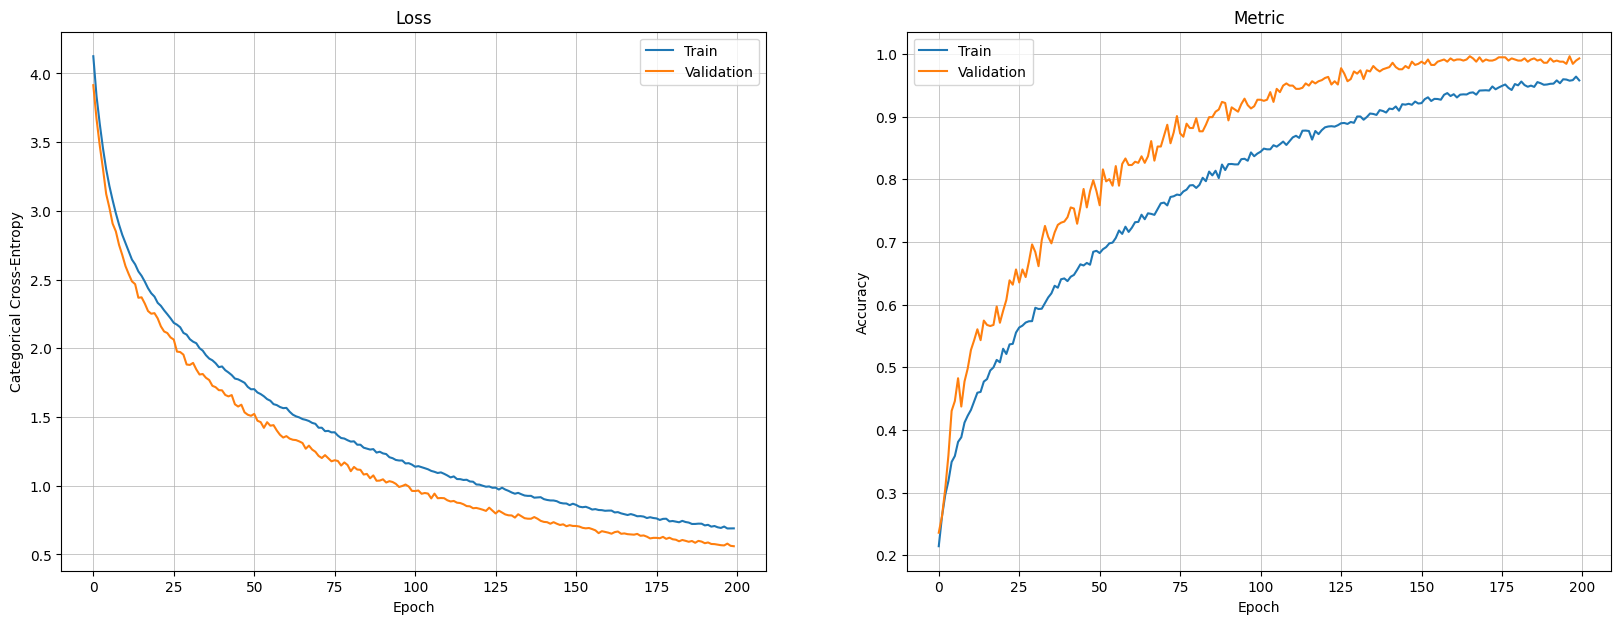

In [31]:
plot_history(history);

In [32]:
model.save("model.h5")

In [33]:
import pickle
pickle.dump(history, open("model_history.pkl", "wb"))

In [34]:
# import tensorflow as tf
# loaded_model = tf.keras.models.load_model(
#     "model.h5",
#     compile=True,
# )

In [35]:
res = model.evaluate(ds_test, return_dict=True)
res

18/18 [==============================] - 1s 25ms/step - loss: 0.5699 - accuracy: 0.9896


{'loss': 0.5699490308761597, 'accuracy': 0.9895833134651184}

In [36]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in ds_test:  # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    #    y_pred.append(preds)
    #    y_pred.append((preds > 0.5))
    y_pred.append((preds > 0.5) * 1)

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis=0)
predicted_labels = tf.concat([item for item in y_pred], axis=0)

1/1 [==============================] - 0s 163ms/step


In [44]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix, accuracy_score
print(classification_report(correct_labels, predicted_labels, target_names=label_dict.keys()))

              precision    recall  f1-score   support

   happiness       1.00      1.00      1.00      1125
    surprise       0.99      0.98      0.99       620
        fear       1.00      0.96      0.98       456
    contempt       1.00      0.88      0.94       166
       anger       1.00      0.99      0.99       712
  neutrality       1.00      0.99      0.99       419
     sadness       1.00      0.99      1.00       597
     disgust       1.00      0.97      0.99       351

   micro avg       1.00      0.98      0.99      4446
   macro avg       1.00      0.97      0.98      4446
weighted avg       1.00      0.98      0.99      4446
 samples avg       0.98      0.98      0.98      4446



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
